In [1]:
# Importing the neccessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl

from scipy import stats

import networkx as nx
import powerlaw

import collections
import random
import heapq

import math
from math import pi

C:\Users\Domonkos\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Domonkos\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Domonkos\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Functions
#### Function for getting all the coordinates of a line between two points

In [2]:
def intermediates(p1, p2, nb_points=8):
    
    x_spacing = (p2[0] - p1[0]) / (nb_points + 1)
    y_spacing = (p2[1] - p1[1]) / (nb_points + 1)

    return [[p1[0] + i * x_spacing, p1[1] +  i * y_spacing] 
            for i in range(1, nb_points+1)]

#### Function for calculating the polar coordinates from the Cartesian coordinates

In [3]:
def polar_coord(x, y):
    
    r = np.sqrt(x**2 + y**2)
    
    if y >= 0 and r != 0:
        theta = math.acos(x/r)
    elif y < 0:
        theta = -math.acos(x/r)
        
    return [r, theta]

#### Function for calculating the radial dst

In [4]:
def radial_dst(theta1, theta2):
    
    if theta1 > 0 and theta2 > 0 or theta1 < 0 and theta2 < 0:
        dst = abs(theta2 - theta1)
    elif theta1 == 0 and theta2 > 0 or theta1 == 0 and theta2 < 0 or theta1 > 0 and theta2 == 0 or theta1 < 0 and theta2 == 0:
        dst = abs(theta2 - theta1)
    elif pi/2 >= theta1 > 0 and 0 > theta2 >= -pi/2 or pi/2 >= theta2 > 0 and 0 > theta1 >= -pi/2:
        dst = abs(theta1) + abs(theta2)
    elif pi/2 > theta1 >= 0 and -pi/2 > theta2 > -pi or pi/2 > theta2 >= 0 and -pi/2 > theta1 > -pi:
        dst = abs(theta2) + abs(theta1)
    elif 0 > theta1 >= -pi/2 and pi > theta2 > pi/2 or 0 > theta2 >= -pi/2 and pi > theta1 > pi/2:
        dst = abs(theta2) + abs(theta1)
    elif pi >= theta1 > pi/2 and -pi/2 > theta2 >= -pi:
        dst = abs(pi - theta1) + abs(-pi - theta2)
    elif pi >= theta2 > pi/2 and -pi/2 > theta1 >= -pi:
        dst = abs(pi - theta2) + abs(-pi - theta1)
    elif theta1 == 0 and theta2 == 0:
        dst = 0
    
    return dst

## Generating the circle

In [5]:
# Setting the parameters of the circle

t = np.array(range(0,int(round(2*math.pi, 3)*1000)))/1000
r = 1
a = 0
b = 0

# Creating the circle circumf.

circumf_x = r * np.array([math.cos(i) for i in t]) + a
circumf_y = r * np.array([math.sin(i) for i in t]) + b

In [6]:
# Getting all the inner points of the circle

inner_coord = []

for i in range(0,len(circumf_x)):
    inner_coord += intermediates([0,0], [circumf_x[i],circumf_y[i]], 100)
    
# Transforming the inner_coord list of lists into np.array

inner_x = np.array(inner_coord).T[0]
inner_y = np.array(inner_coord).T[1]

# Appending all the x and y coordinates together

all_x_coord = list(circumf_x) + list(inner_x)
all_y_coord = list(circumf_y) + list(inner_y)

In [7]:
# Generating the polar coordinates from the Cartesian coordinates

r_values = []
theta_values = []

for i in range(0,len(all_x_coord)):
    
    temp = polar_coord(all_x_coord[i], all_y_coord[i])
    
    r_values.append(temp[0])
    theta_values.append(temp[1])

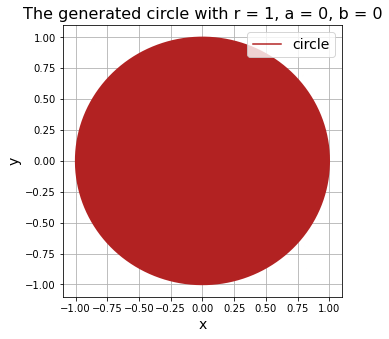

In [8]:
# Plotting the circle

plt.figure(figsize = (5,5))
plt.plot(all_x_coord, all_y_coord, color = 'firebrick', label = 'circle')

plt.title('The generated circle with r = ' + str(r) + ', a = ' + str(a) + ', b = ' + str(b), fontsize = 16)
plt.xlabel('x', fontsize = 14)
plt.ylabel('y', fontsize = 14)

plt.legend(fontsize = 14)
plt.grid()
plt.show()

# Functions

### Function for generating and adding nodes to the circle

In [76]:
def generating_circle(new_num_nodes_to_generate, all_x_coord, all_y_coord, r_values, theta_values, T, beta, m):
    
    # Node list
    nodes = []    

    # Creating lists to save the generated coordinates
    generated_coordinates = []

    # Saving all the generated numbers in a list
    generated_random_nums = []
    
    # Saving the coordinates as a temp list
    temp_temp_list = []

    # Generating random numbers and placing them in the circle
    
    for i in range(0,num_nodes_to_generate_first):

        #random index
        random_index = random.randint(0,len(all_x_coord))
        generated_random_nums.append(random_index)

        #saving the generated coordinates into a dictionary
        temp = [all_x_coord[random_index], all_y_coord[random_index], r_values[random_index], theta_values[random_index]]
        temp_temp_list.append(temp)

        generated_coordinates.append((temp, (i+1), -999))
        
    # Appending the first node
    nodes.append([[all_x_coord[random_index], all_y_coord[random_index]], i+1])


    # Generating random numbers and placing them in the circle

    for i in range(0,new_num_nodes_to_generate):

        #random index
        while random_index in generated_random_nums:
            random_index = random.randint(0,len(all_x_coord))
        generated_random_nums.append(random_index)

        #getting the coordinates
        temp = [all_x_coord[random_index], all_y_coord[random_index], r_values[random_index], theta_values[random_index]]
        temp_temp_list.append(temp)
        
        #new node
        nodes.append([[all_x_coord[random_index], all_y_coord[random_index]], i + num_nodes_to_generate_first + 1])
        
        #temp list for the probabilities
        prob_temp_list = []

        #measuring the distance between the new node and all the previous nodes
        for j in range(0,len(temp_temp_list)):
            
            #checking if theta > 0:
            if radial_dst(temp[3], temp_temp_list[j][3]) > 0.0001:
                
                #calculating the R_i
                if beta < 1:
                    R_i = r_values[i] - math.log( (2*T / math.sin(T*math.pi)) * (1 - math.exp((beta-1) * r_values[i]))/(m * (1 - beta)))
                if beta == 1:
                    R_i = r_values[i] - math.log( (2*T / math.sin(T*math.pi)) * 2*r_values[i]/m)

                #calling the radial_dst func and saving the theta values in a list
                x_st = temp[2] + temp_temp_list[j][2] + math.log(radial_dst(temp[3], temp_temp_list[j][3])/2)
                p_st = (1 / (1 + math.exp((x_st - R_i) / T)))
                
                #if probability > p_st, node appended
                #p_st_rand = random.randint(0,10000) / 10000

                #if p_st_rand <= p_st:
                    #appending the new node to the generated coordinates
                    #generated_coordinates.append((temp, i + num_nodes_to_generate_first + 1, j + 1))
                
                #appending the probabilities to the temp list
                prob_temp_list.append([p_st, (temp, i + num_nodes_to_generate_first + 1, j + 1)])
                
        #filtering out the highest probabilities and appending to the generated_coordinates
        temp_largest_values = heapq.nlargest(m, prob_temp_list)
        for kk in range(0,len(temp_largest_values)):
            generated_coordinates.append(temp_largest_values[kk][1])

    return [generated_coordinates, nodes, temp_temp_list]

### Function for plotting the results of the circle with nodes

In [95]:
def circle_plot(new_num_nodes_to_generate, inner_x, inner_y, circumf_x, circumf_y, generated_coordinates):

    # Plotting the circle with the generated points

    plt.figure(figsize = (10,10))

    # Plotting the circle
    plt.plot(inner_x, inner_y, color = 'gold', alpha = 0.1)
    plt.plot(circumf_x, circumf_y, color = 'orange')

    # Plotting the original nodes
    for i in range(0,num_nodes_to_generate_first):
        plt.plot(generated_coordinates[i][0][0], generated_coordinates[i][0][1], 'o', color = 'black', markersize = 5)

    # Plotting the newly connected nodes
    for i in range(1, len(generated_coordinates)):
        plt.plot(generated_coordinates[i][0][0], generated_coordinates[i][0][1], 'o', color = 'firebrick', markersize = 5)
        plt.plot([generated_coordinates[i][0][0], generated_coordinates[generated_coordinates[i][2]-1][0][0]], [generated_coordinates[i][0][1], generated_coordinates[generated_coordinates[i][2]-1][0][1]], color = 'black', linewidth = 0.2)

    # Setting the title and labels
    plt.title('The generated circle with r = ' + str(r) + ', m = ' + str(m) + ', beta = ' + str(beta) + ', nodes = ' + str(new_num_nodes_to_generate+1), fontsize = 16)
    plt.xlabel('x', fontsize = 14)
    plt.ylabel('y', fontsize = 14)

    # Setting the grid
    plt.grid()

    #plt.savefig('cirlce_network_' + str(beta) + '.jpg', dpi = 600)

    plt.show()

### Function for generating a corresponding network

In [11]:
def network_gen(generated_coordinates):

    # Getting the nodes and edges from the generated data set

    nodes = [generated_coordinates[i][1] for i in range(0,len(generated_coordinates))]
    edges = [generated_coordinates[i][2] for i in range(1,len(generated_coordinates))]

    # Creating the graph

    circle_graph = nx.Graph()

    # Adding the nodes

    for i in range(0,len(nodes)):
        circle_graph.add_node(nodes[i])

    # Adding the weights

    for i in range(1,len(nodes)):
        circle_graph.add_edge(nodes[i], edges[i-1])
        
    return circle_graph

### Function for plotting the network layout

In [12]:
def network_plot(graph):

    # Plotting the graph

    plt.figure(figsize = (9,9))

    # Setting the layout

    pos_cust = nx.kamada_kawai_layout(graph)

    # Drawing the graph

    nx.draw(graph, pos = pos_cust, node_color = 'firebrick', node_size=10, width = 0.5)

    #plt.savefig('network_layout_circle.jpg', dpi=400)

### Function for calculating the k and attractiveness values

In [13]:
def attractiveness_calc(circle_graph):

    # Degree distribution, connections

    k = np.array(nx.degree(circle_graph)).T[1]

    # Power law fit

    fit = powerlaw.Fit(k)
    gamma = fit.power_law.alpha
    A = (gamma-2)*m

    # Attractiveness

    p_attr = []

    for i in range(0,len(k)):
        p_attr.append(m * (k[i] - m + A) / ((i+1) * (m + A)))

    # Creating res dict for the values

    res = {p_attr[i]: k[i] for i in range(len(p_attr))}

    # Calculating the mean values of same degree nodes

    new_values_k = []
    new_keys_attr = []

    for i in range(0,max(k)):

        #getting the indices of the same elements
        indices = [l for l, x in enumerate(list(res.values())) if x == i]

        #if the indices list is not empty
        if indices != []:

            #initialising mean_value
            mean_value = 0

            #going through the indices
            for j in range(0,len(indices)):
                mean_value += p_attr[indices[j]]

            #getting the mean value of the results
            mean_value = mean_value / len(indices)

            #appending the results
            new_values_k.append(mean_value)
            new_keys_attr.append(i)


    # Normalising the results

    new_keys_norm = np.array(new_keys_attr)/len(k)
    
    return [new_values_k, new_keys_norm]

### Function for plotting the k- attractiveness function

In [14]:
def attr_k_plot(new_values_k, new_keys_norm):

    # Fitting on the results

    results = np.polyfit(np.log(new_values_k),np.log(new_keys_norm), 1)
    R_squared = (stats.linregress(np.log(new_values_k),np.log(new_keys_norm)).rvalue)**2

    # Plotting the k - attractiveness values

    plt.figure(figsize = (10,7))

    plt.scatter(new_values_k, new_keys_norm, color = 'orange', label = 'values')
    plt.plot(np.exp(np.log(np.array(new_values_k))), np.exp(results[0]*np.log(np.array(new_values_k)) + results[1]), color = 'black', label = 'fit')

    plt.title('Relation between the k and attractiveness with m = ' + str(m) + ' and node_num = ' + str(new_num_nodes_to_generate), fontsize = 18)
    plt.xlabel('Degree distribution', fontsize = 14)
    plt.ylabel('Attractiveness', fontsize = 14)

    plt.xscale('log')
    plt.yscale('log')
    plt.legend(fontsize = 14)
    plt.grid()

    textstr = 'R squared value: ' + str(round(R_squared,3))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.00028, 0.09, textstr, fontsize=14, verticalalignment='top', bbox=props)

    #plt.savefig('attractiveness_k_m' + str(m) + '_noden' + str(new_num_nodes_to_generate) + '.jpg', dpi = 500)

    plt.show()

### Function for power law distribution and plotting

In [15]:
def powerlaw_plotting(graph, name):
    
    # Power law distribution and clust coeff
    fit = powerlaw.Fit(np.array(nx.degree(graph)).T[1])
    clust = np.mean(list(nx.clustering(graph).values()))
    
    # Printing the clust coeff and power law alpha value
    print("\nClustering coefficient: ", clust)
    print("Powerlaw coefficient: gamma =", fit.power_law.alpha, "\n")

    # Plotting the results
    plt.figure(figsize=(10,7))

    fit.power_law.plot_pdf(color = 'orange', linestyle='--', label='fit ccdf')
    fit.plot_pdf(color = 'black', label = 'original')

    plt.title("Probability density function of the " + name + " - powerlaw fitting", fontsize = 14)
    plt.xlabel("Degree", fontsize = 14)
    plt.ylabel("Probability", fontsize = 14)

    plt.legend(fontsize = 15)
    plt.grid()
    
    #plt.savefig(name + "_powerlaw_fit.jpg", dpi = 400)
    
    plt.show()

### Function for printing the gamma - beta relation

In [16]:
def gamma_beta_print(gamma_list, beta_list, y_lower, y_upper, x_lower, x_upper, save_img):
    
    # Calculating the theoretical values
    
    theoretical_gamma_list = 1 + 1/np.array(beta_list)
    
    # Plotting the results
    
    plt.figure(figsize = (10,7))
    
    plt.scatter(beta_list, gamma_list, color = 'black', label = 'fitted values', linewidths = 0.1)
    plt.plot(beta_list, theoretical_gamma_list, color = 'orange', label = 'theoretical values')
    
    plt.title('Theoretical and actual values of gamma in function of beta.', fontsize = 18)
    plt.xlabel('Beta values', fontsize = 14)
    plt.ylabel('Gamma values', fontsize = 14)
    
    plt.ylim(y_lower,y_upper)
    plt.xlim(x_lower, x_upper)
    
    plt.grid()
    plt.legend(fontsize = 15)
    
    if save_img == True:
        plt.savefig("beta_gamma_relation.jpg", dpi = 400)
    
    plt.show()

### Creating a function for calculating the degree distribution

In [17]:
def plot_degree_histogram(g, normalized=False):

    aux_y = nx.degree_histogram(g)
    aux_x = np.arange(0,len(aux_y)).tolist()
    n_nodes = g.number_of_nodes()
    
    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i]/n_nodes
    
    return aux_x, aux_y

# Calling the functions - generating the PSO network

In [18]:
# Plot for the power law distribution
#powerlaw_plotting(circle_network, 'PSO')

# Plotting the gamma-beta distribution
#gamma_beta_print(gamma_values, beta_values)

# Plotting the generated network
#network_plot(circle_network)

# Plotting the circle 
#mpl.rcParams['agg.path.chunksize'] = 600
#circle_plot(new_num_nodes_to_generate, inner_x, inner_y, circumf_x, circumf_y, coordinates)

# Plotting the results for calculating the attractiveness - k function
#attr_k_plot(attractiveness_calc(circle_network)[0], attractiveness_calc(circle_network)[1])

In [86]:
# Setting some variables

num_nodes_to_generate_first = 1
new_num_nodes_to_generate = 1000

m = 2
T = 0.8
beta_values = np.array(range(90,101))/100

# Creating list to store gamma values

gamma_values = []

for betas in beta_values:

    # Generating the PSO
    coordinates_temp = generating_circle(new_num_nodes_to_generate, all_x_coord, all_y_coord, r_values, theta_values, T, betas, m)
    coordinates = coordinates_temp[0]
    nodes = coordinates_temp[1]

    # Generating the actual network
    circle_network = network_gen(coordinates)

    # Calculating the power law value
    fit = powerlaw.Fit(np.array(nx.degree(circle_network)).T[1])
    gamma_values.append(fit.power_law.alpha)

Calculating best minimal value for power law fit
C:\Users\Domonkos\anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


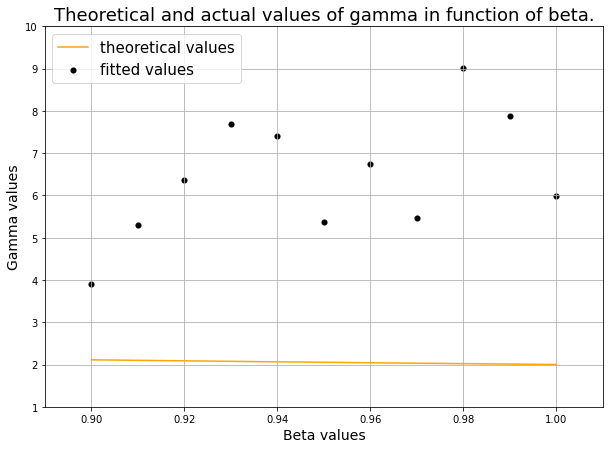

In [91]:
# Plotting the gamma-beta distribution

y_lower = 1
y_upper = 10

x_lower = 0.89
x_upper = 1.01

save_img = True

gamma_beta_print(gamma_values, beta_values, y_lower, y_upper, x_lower, x_upper, save_img)

In [89]:
gamma_values

[3.9059939266758104,
 5.2952314919417995,
 6.3615001840593655,
 7.686318152015888,
 7.396526236070562,
 5.369066233681035,
 6.734185146510014,
 5.456559762004684,
 9.013617494713145,
 7.8860232169360645,
 5.995987238265914]

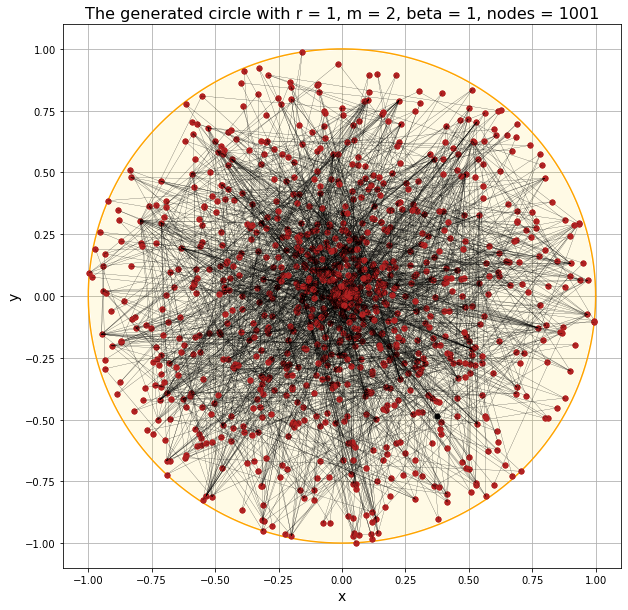

In [96]:
#mpl.rcParams['agg.path.chunksize'] = 600
circle_plot(new_num_nodes_to_generate, inner_x, inner_y, circumf_x, circumf_y, coordinates)